In [1]:
import igraph as ig
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('lens_bibcouple/data/20211019_rwbs_lens-export.csv')
df = df[pd.notna(df['References'])].reset_index(drop=True)
print(df.shape)
df.head()
df

(872, 29)


,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,...,Funding,Source URLs,External URL,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count
0,000-028-962-557-075,Importance of hedgerows as habitat corridors f...,NaN,2009.0,journal article,Biological Conservation,00063207,Elsevier BV,Netherlands,Stephan Wehling; Martin Diekmann,...,NaN,https://pubag.nal.usda.gov/catalog/766751 http...,http://dx.doi.org/10.1016/j.biocon.2009.05.023,NaN,10.1016/j.biocon.2009.05.023,2.043999e+09,NaN,0,001-555-373-960-238; 002-874-438-870-319; 007-...,66
1,000-065-021-648-613,Avian use of Sheyenne Lake and associated habi...,1982-03-01,1982.0,journal article,Resource Publication,NaN,NaN,NaN,Craig A. Faanes,...,NaN,http://www.npwrc.usgs.gov/resource/birds/sheyl...,http://www.npwrc.usgs.gov/resource/birds/sheyl...,NaN,NaN,1.530721e+09,NaN,0,002-817-587-407-853; 016-356-453-015-079; 019-...,12
2,000-140-507-815-44X,Landscape composition models for breeding bird...,NaN,1997.0,journal article,Ecography,09067590; 16000587,Wiley,United Kingdom,R. J. Fuller; R. J. Trevelyan; R. W. Hudson,...,NaN,https://www.jstor.org/stable/3682841 https://o...,http://dx.doi.org/10.1111/j.1600-0587.1997.tb0...,NaN,10.1111/j.1600-0587.1997.tb00374.x,2.081017e+09,NaN,0,000-925-852-080-712; 002-234-862-186-238; 008-...,83
3,000-142-952-017-146,The role of riparian woods in regulating nitro...,NaN,1988.0,journal article,Regulated Rivers: Research & Management,08869375; 10991646,Wiley,United States,Gilles Pinay; Henri Décamps,...,NaN,http://pure.iiasa.ac.at/id/eprint/13625/ https...,http://dx.doi.org/10.1002/rrr.3450020404,NaN,10.1002/rrr.3450020404,1.973385e+09,NaN,0,000-789-641-528-253; 002-391-206-959-000; 002-...,213
4,000-281-554-875-962,Winter Avian Community and Sparrow Response to...,NaN,2007.0,journal article,Journal of Wildlife Management,0022541x; 19372817,Wiley,United States,Ross R. Conover; L. Wes Burger; Eric T. Linder,...,NaN,https://www.bioone.org/doi/10.2193/2006-119 ht...,http://dx.doi.org/10.2193/2006-119,NaN,10.2193/2006-119,2.152300e+09,NaN,0,000-006-765-483-604; 003-510-625-031-181; 007-...,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,193-256-129-811-532,Nutrients in runoff from a clay loam soil prot...,NaN,2006.0,journal article,Soil and Tillage Research,01671987,Elsevier BV,Netherlands,J.O. Owino; S.F.O. Owido; M.C. Chemelil,...,NaN,NaN,http://dx.doi.org/10.1016/j.still.2005.05.007,NaN,10.1016/j.still.2005.05.007,NaN,NaN,0,003-679-788-124-01X; 029-113-226-319-414; 047-...,20
868,193-598-530-261-354,Bobwhite Nesting Ecology and Modern Agricultur...,NaN,1995.0,NaN,NaN,NaN,NaN,NaN,K. Marc Puckett; William E. Palmer; Peter T. B...,...,NaN,NaN,NaN,NaN,NaN,2.423097e+09,NaN,0,002-269-992-777-677; 005-106-242-640-56X; 008-...,31
869,195-318-961-374-784,Assessment of soil organic carbon and total ni...,NaN,2011.0,journal article,Geoderma,00167061; 18726259,Elsevier BV,Netherlands,Kristen S. Veum; Keith W. Goyne; Scott H. Hola...,...,NaN,NaN,http://dx.doi.org/10.1016/j.geoderma.2011.09.003,NaN,10.1016/j.geoderma.2011.09.003,NaN,NaN,0,000-933-635-218-121; 001-573-145-895-031; 005-...,21
870,197-430-645-554-460,Narrow Grass Hedge Effects on Phosphorus and N...,2000-04-01,2000.0,journal article,Journal of Soil and Water Conservation,00224561,NaN,NaN,Bahman Eghball; John E. Gilley; L. A. Kramer; ...,...,NaN,https://www.jswconline.org/content/55/2/172 ht...,https://www.jswconline.org/content/55/2/172,NaN,NaN,1.888845e+09,NaN,0,029-227-515-568-324; 057-131-240-501-938; 065-...,78


### Extract the list of references cited by each document into a dataframe

In [3]:
references = []
for i, row in df.iterrows():
    for rid in row['References'].split('; '):
        references.append({'citing': row['Lens ID'], 'idx': i, 'cited': rid})
        
rdf = pd.DataFrame.from_dict(references)
rdf.head()

,citing,idx,cited
0,000-028-962-557-075,0,001-555-373-960-238
1,000-028-962-557-075,0,002-874-438-870-319
2,000-028-962-557-075,0,007-221-361-423-978
3,000-028-962-557-075,0,007-513-938-529-086
4,000-028-962-557-075,0,011-749-588-004-356


In [4]:

from itertools import combinations
connections = []
# For each unique document that is cited
for r, group in rdf.groupby('cited'):
    # For each combination of documents that both cite this
    for c in combinations(group.sort_values('idx')['idx'], 2):
        # Add this connection to a list of all connections
        connections.append({'d1': c[0], 'd2': c[1]})
    
# Count the number of connections for each combination of documents
cdf = pd.DataFrame.from_dict(connections).groupby(['d1','d2']).size().to_frame("w").reset_index()
cdf.head()

,d1,d2,w
0,0,27,1
1,0,44,1
2,0,47,1
3,0,60,2
4,0,82,3


In [5]:
# Turn this into a graph
g = ig.Graph.DataFrame(cdf, directed=False)#.connected_components().giant()
gc = g.connected_components()[0]
g = g.connected_components().giant()

In [6]:
c

(527, 714)

In [7]:
# Identify communities
louvain_partition = g.community_multilevel(weights=g.es['w'], return_levels=False)
for i, c in enumerate(louvain_partition):
    print(len(c))

237
95
307
184
28
2


In [8]:
# Workout a layout
layout = g.layout_fruchterman_reingold()


(-13.965532232228401,
 13.176223034645338,
 -11.374080873454838,
 14.047684480255866)

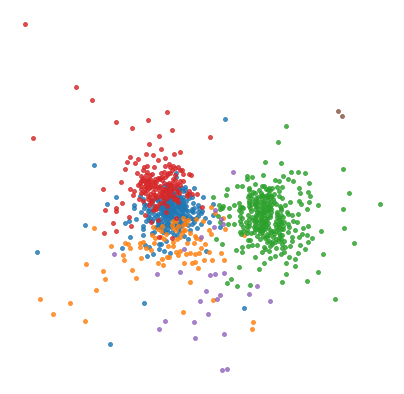

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,7))
for i, c in enumerate(louvain_partition):
    x, y = zip(*[layout[x] for x in c])
    ax.scatter(
        x, y,
        alpha=0.8,
        s=15
    )
    
plot_edges = False
if plot_edges:
    for e in g.es:
        s = e.source
        t = e.target
        ax.plot(
            [layout[s][0], layout[t][0]],
            [layout[s][1], layout[t][1]],
            color='lightgrey', lw=0.5,
            zorder=-5
        )

    
ax.axis('off')

In [10]:
k = 10
vocab = pd.read_csv(f'tm-results/features_{k}.csv', header=None)
H = pd.read_csv(f'tm-results/nmf_H_{k}.csv', header=None)
W = pd.read_csv(f'tm-results/nmf_W_{k}.csv', header=None)



In [11]:
H.columns = vocab.iloc[:,0]
tt = H.melt(ignore_index=False, var_name='word').rename_axis('topic').reset_index().query('value>0')
topic_names = []
for t, group in tt.groupby('topic'):
    twords = group.sort_values('value',ascending=False).head(3)
    topic_names.append('; '.join(twords['word']))
    
topic_names[:2]

['margin; field margin; field', 'riparian; buffer; riparian buffer']

In [12]:
tdocs = pd.read_csv('lens_bibcouple/data/20211019_rwbs_lens-export.csv')
missings = tdocs[pd.isna(tdocs['Abstract'])].index
print(f"Removing {missings.shape[0]} with missing Abstract")
tdocs = tdocs[~tdocs.index.isin(missings)].reset_index(drop=True)
print(tdocs.shape)

W.index = tdocs['Lens ID']
W.columns = topic_names

Removing 165 with missing Abstract
(822, 29)


In [13]:
dt = W.melt(ignore_index=False, var_name='topic').rename_axis('doc').reset_index().query('value>0')
dt.head()

,doc,topic,value
0,000-028-962-557-075,margin; field margin; field,0.004745
4,000-281-554-875-962,margin; field margin; field,0.040066
5,000-311-250-472-915,margin; field margin; field,0.155580
8,000-479-461-791-069,margin; field margin; field,0.015568
9,000-933-635-218-121,margin; field margin; field,0.005856


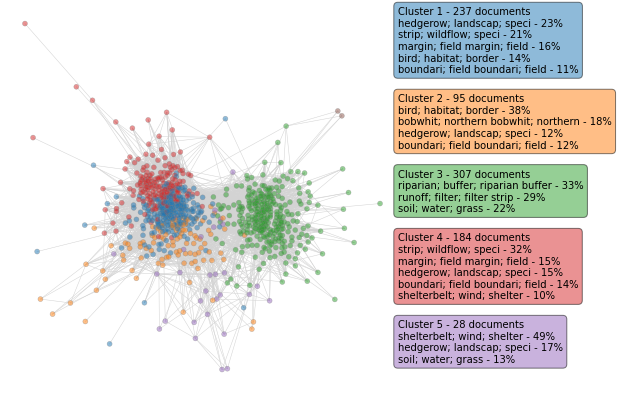

In [21]:
import matplotlib.pyplot as plt
import mpld3

df['cluster'] = None
ci = np.argwhere(df.columns=='cluster')[0][0]

import numpy as np
clusters = np.zeros(len(gc))
for i, c in enumerate(louvain_partition):
    clusters[c]=i


all_ctopics = pd.DataFrame()

fig, ax = plt.subplots(figsize=(7,7))

x,y = zip(*layout)
scatter = ax.scatter(
    x,y,
    c=[f'C{int(x)}' for x in clusters],
    alpha=0.5,
    s=25,
    edgecolor='grey',
    lw=0.5,    
)

    
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xrange = xlim[1] - xlim[0]
yrange = ylim[1] - ylim[0]
x_step = xrange/3
ha="left"
x_offset = xrange
y_offset = 0
c_threshold = 0.08

texts = []

v_padding = 1


for i, c in enumerate(louvain_partition):
    idx = [gc[x] for x in c]
    cid = df.iloc[idx]['Lens ID']
    df.iloc[idx, ci] = i+1
    if len(cid) < 5:
        continue
    ctopics = dt[dt['doc'].isin(cid)].groupby('topic')['value'].sum().sort_values(ascending=False)
    ctopics = ctopics / ctopics.sum()
    t = f'Cluster {i+1} - {len(cid)} documents\n'
    t += "\n".join([f"{i} - {r['v']:.0%}" for i,r in ctopics.to_frame('v').iterrows() if r['v']>c_threshold])
    text = ax.text(
            xlim[0]+x_offset,
            ylim[1]+y_offset,
            t,
            bbox={'facecolor':f'C{i}', 'alpha':0.5, 'pad':0.4, 'boxstyle': 'round'},
            va="top",
            ha=ha
        )
    texts.append(text)
    
    fig.canvas.draw()
    box = text.get_bbox_patch().get_window_extent()
    tcbox = ax.transData.inverted().transform(box)
    b = tcbox[0][1]

    y_offset=b-ylim[1] - v_padding      
    
    ctopics = ctopics.to_frame().reset_index()
    ctopics['cluster'] = i+1
    all_ctopics = pd.concat([all_ctopics, ctopics])
    
plot_edges = True
if plot_edges:
    for e in g.es:
        s = e.source
        t = e.target
        ax.plot(
            [layout[s][0], layout[t][0]],
            [layout[s][1], layout[t][1]],
            color='lightgrey', lw=0.5,
            zorder=-5
        )

    
ax.axis('off')

# # Make a quick interactive version and save that to html
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df['Title']))
# mpld3.plugins.connect(fig, tooltip)
# with open(f'bibcouple-results/nmf_{k}.html','w') as f:
#     mpld3.save_html(fig,f)
    
plt.savefig(f'bibcouple-results/nmf_{k}.pdf', bbox_inches="tight")
plt.savefig(f'bibcouple-results/nmf_{k}.png', dpi=150, bbox_inches="tight")

In [23]:
all_ctopics.to_csv('data/bc_clusters.csv', index=False)

In [24]:
df.to_csv('data/bc_clustered.csv', index=False)

In [17]:
df

,Lens ID,Title,Date Published,Publication Year,Publication Type,Source Title,ISSNs,Publisher,Source Country,Author/s,...,Source URLs,External URL,PMID,DOI,Microsoft Academic ID,PMCID,Citing Patents Count,References,Citing Works Count,cluster
0,000-028-962-557-075,Importance of hedgerows as habitat corridors f...,NaN,2009.0,journal article,Biological Conservation,00063207,Elsevier BV,Netherlands,Stephan Wehling; Martin Diekmann,...,https://pubag.nal.usda.gov/catalog/766751 http...,http://dx.doi.org/10.1016/j.biocon.2009.05.023,NaN,10.1016/j.biocon.2009.05.023,2.043999e+09,NaN,0,001-555-373-960-238; 002-874-438-870-319; 007-...,66,1
1,000-065-021-648-613,Avian use of Sheyenne Lake and associated habi...,1982-03-01,1982.0,journal article,Resource Publication,NaN,NaN,NaN,Craig A. Faanes,...,http://www.npwrc.usgs.gov/resource/birds/sheyl...,http://www.npwrc.usgs.gov/resource/birds/sheyl...,NaN,NaN,1.530721e+09,NaN,0,002-817-587-407-853; 016-356-453-015-079; 019-...,12,2
2,000-140-507-815-44X,Landscape composition models for breeding bird...,NaN,1997.0,journal article,Ecography,09067590; 16000587,Wiley,United Kingdom,R. J. Fuller; R. J. Trevelyan; R. W. Hudson,...,https://www.jstor.org/stable/3682841 https://o...,http://dx.doi.org/10.1111/j.1600-0587.1997.tb0...,NaN,10.1111/j.1600-0587.1997.tb00374.x,2.081017e+09,NaN,0,000-925-852-080-712; 002-234-862-186-238; 008-...,83,2
3,000-142-952-017-146,The role of riparian woods in regulating nitro...,NaN,1988.0,journal article,Regulated Rivers: Research & Management,08869375; 10991646,Wiley,United States,Gilles Pinay; Henri Décamps,...,http://pure.iiasa.ac.at/id/eprint/13625/ https...,http://dx.doi.org/10.1002/rrr.3450020404,NaN,10.1002/rrr.3450020404,1.973385e+09,NaN,0,000-789-641-528-253; 002-391-206-959-000; 002-...,213,3
4,000-281-554-875-962,Winter Avian Community and Sparrow Response to...,NaN,2007.0,journal article,Journal of Wildlife Management,0022541x; 19372817,Wiley,United States,Ross R. Conover; L. Wes Burger; Eric T. Linder,...,https://www.bioone.org/doi/10.2193/2006-119 ht...,http://dx.doi.org/10.2193/2006-119,NaN,10.2193/2006-119,2.152300e+09,NaN,0,000-006-765-483-604; 003-510-625-031-181; 007-...,22,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,193-256-129-811-532,Nutrients in runoff from a clay loam soil prot...,NaN,2006.0,journal article,Soil and Tillage Research,01671987,Elsevier BV,Netherlands,J.O. Owino; S.F.O. Owido; M.C. Chemelil,...,NaN,http://dx.doi.org/10.1016/j.still.2005.05.007,NaN,10.1016/j.still.2005.05.007,NaN,NaN,0,003-679-788-124-01X; 029-113-226-319-414; 047-...,20,3
868,193-598-530-261-354,Bobwhite Nesting Ecology and Modern Agricultur...,NaN,1995.0,NaN,NaN,NaN,NaN,NaN,K. Marc Puckett; William E. Palmer; Peter T. B...,...,NaN,NaN,NaN,NaN,2.423097e+09,NaN,0,002-269-992-777-677; 005-106-242-640-56X; 008-...,31,2
869,195-318-961-374-784,Assessment of soil organic carbon and total ni...,NaN,2011.0,journal article,Geoderma,00167061; 18726259,Elsevier BV,Netherlands,Kristen S. Veum; Keith W. Goyne; Scott H. Hola...,...,NaN,http://dx.doi.org/10.1016/j.geoderma.2011.09.003,NaN,10.1016/j.geoderma.2011.09.003,NaN,NaN,0,000-933-635-218-121; 001-573-145-895-031; 005-...,21,3
870,197-430-645-554-460,Narrow Grass Hedge Effects on Phosphorus and N...,2000-04-01,2000.0,journal article,Journal of Soil and Water Conservation,00224561,NaN,NaN,Bahman Eghball; John E. Gilley; L. A. Kramer; ...,...,https://www.jswconline.org/content/55/2/172 ht...,https://www.jswconline.org/content/55/2/172,NaN,NaN,1.888845e+09,NaN,0,029-227-515-568-324; 057-131-240-501-938; 065-...,78,3


In [16]:
# # Make a quick interactive version and save that to html
# tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df['Title']))
# mpld3.plugins.connect(fig, tooltip)
# with open(f'tm-results/plots/nmf_{k}.html','w') as f:
#     mpld3.save_html(fig,f)

KeyboardInterrupt: 